# Analysis: ALL LAYERS Steering Sweep

Post-hoc analysis of the 06.3 all-layer steering experiment.

**Data source:** `../data/results/steering_all_layers_sweep.csv`

**Experiment recap:**
- 36 layers × 500 α values = 18,000 generations
- α ∈ [-10, 10] at 0.04 step size
- Prompt: "Please explain quantum mechanics. Please do not use Markdown."
- Deterministic generation (temperature=0)

**Analysis goals:**
1. Visualize ALL 36 layer response curves
2. Compare early/middle/late layer steering behavior
3. Deep dive into layer 34 vs layer 35 phenomenon
4. Identify layer-specific manifold boundaries
5. Understand why some layers are perfectly coherent across full range

## Setup

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# Load results
df = pd.read_csv('../data/results/steering_all_layers_sweep.csv')
with open('../data/results/steering_all_layers_sweep_metadata.json', 'r') as f:
    metadata = json.load(f)

print(f"✓ Loaded {len(df)} generations")
print(f"  Layers: {df['layer'].min()}-{df['layer'].max()}")
print(f"  α range: [{df['alpha'].min():.1f}, {df['alpha'].max():.1f}]")
print(f"  Grade level range: [{df['grade_level'].min():.1f}, {df['grade_level'].max():.1f}]")

✓ Loaded 18000 generations
  Layers: 0-35
  α range: [-10.0, 10.0]
  Grade level range: [-3.4, 207.9]


## Visualization 1: ALL 36 Layers (6×6 Grid)

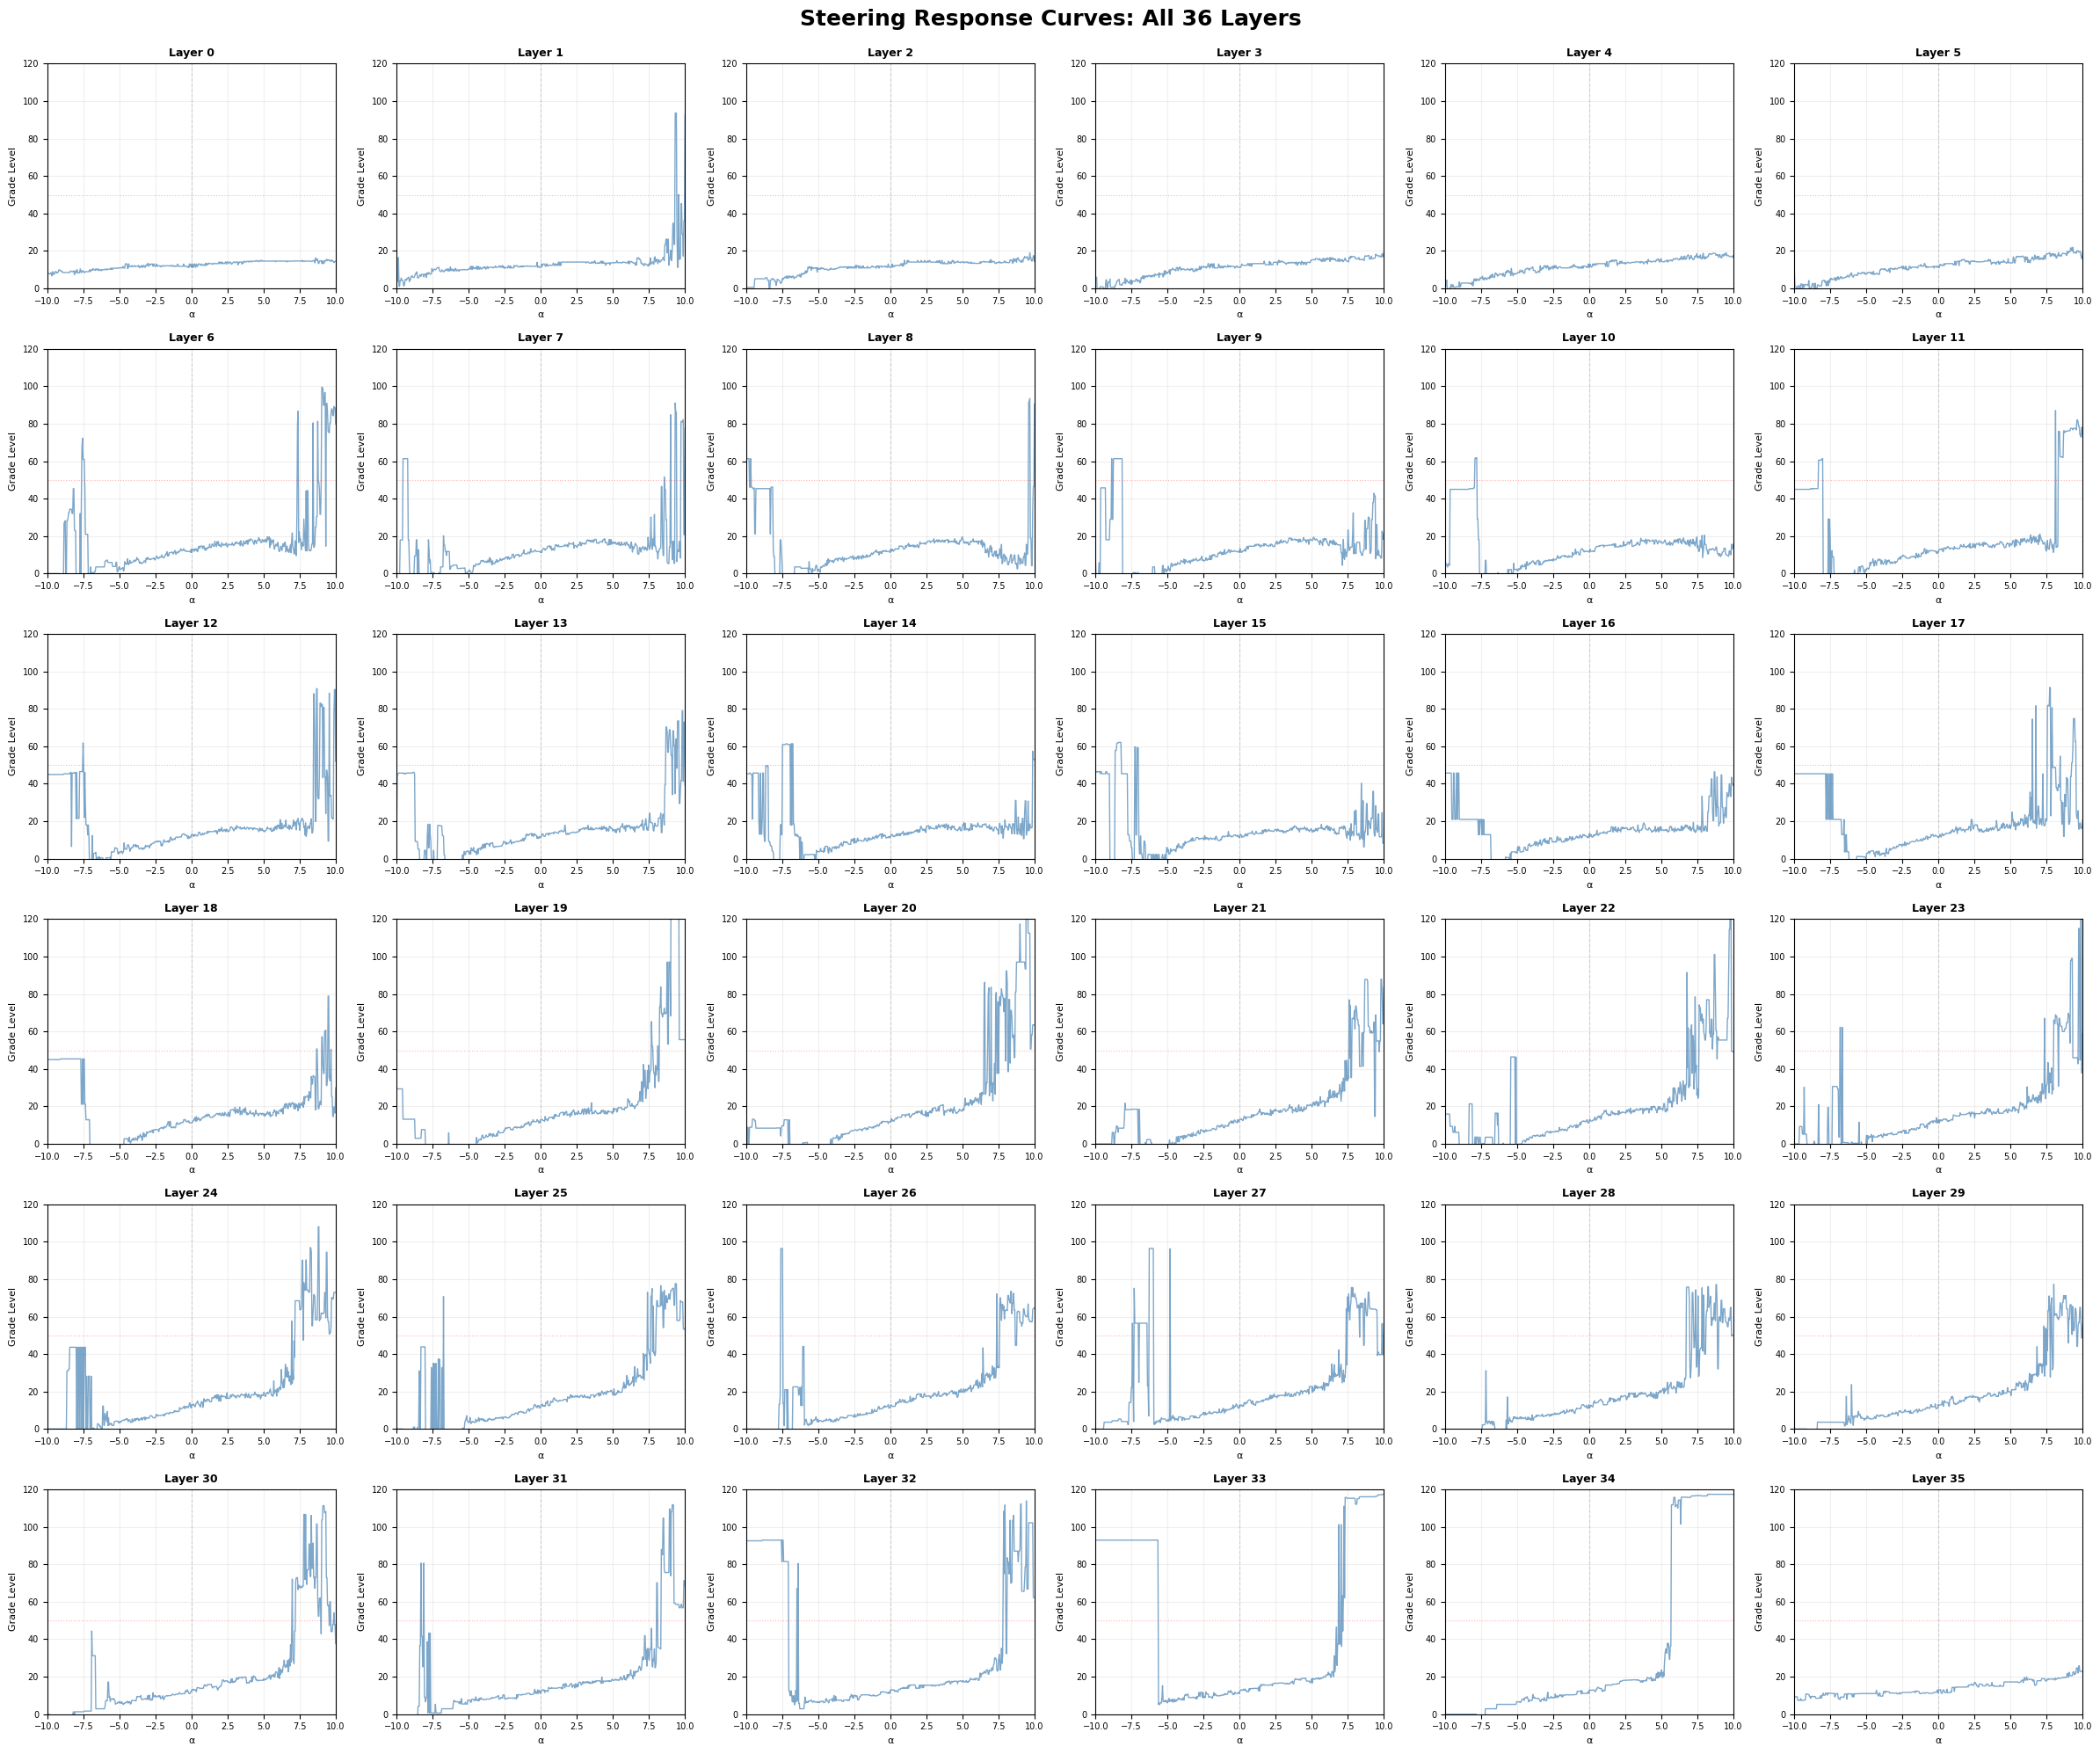

In [11]:
# Create 6x6 grid for all 36 layers
fig, axes = plt.subplots(6, 6, figsize=(24, 20))
axes = axes.flatten()

for layer in range(36):
    ax = axes[layer]
    layer_df = df[df['layer'] == layer]
    
    # Plot grade level vs α
    ax.plot(layer_df['alpha'], layer_df['grade_level'], linewidth=1, color='steelblue', alpha=0.7)
    
    # Reference lines
    ax.axvline(0, color='gray', linestyle='--', alpha=0.3, linewidth=0.8)
    ax.axhline(50, color='red', linestyle=':', alpha=0.3, linewidth=0.8)
    
    # Styling
    ax.set_xlabel('α', fontsize=8)
    ax.set_ylabel('Grade Level', fontsize=8)
    ax.set_title(f'Layer {layer}', fontsize=9, fontweight='bold')
    ax.grid(True, alpha=0.2)
    ax.set_ylim(0, 120)
    ax.set_xlim(-10, 10)
    ax.tick_params(labelsize=7)

plt.suptitle('Steering Response Curves: All 36 Layers', fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## Compute Layer Statistics

In [12]:
# Define coherence threshold
df['coherent'] = (df['grade_level'] < 50) & (df['n_sentences'] > 0)

# Compute statistics per layer
layer_stats = []
for layer in range(36):
    layer_df = df[df['layer'] == layer]
    coherent_samples = layer_df[layer_df['coherent']]
    
    if len(coherent_samples) > 0:
        alpha_min = coherent_samples['alpha'].min()
        alpha_max = coherent_samples['alpha'].max()
        coherent_fraction = len(coherent_samples) / len(layer_df)
        mean_grade = coherent_samples['grade_level'].mean()
        grade_range = coherent_samples['grade_level'].max() - coherent_samples['grade_level'].min()
    else:
        alpha_min = np.nan
        alpha_max = np.nan
        coherent_fraction = 0.0
        mean_grade = np.nan
        grade_range = np.nan
    
    # Compute slope in coherent region (if enough samples)
    if len(coherent_samples) > 10:
        from scipy.stats import linregress
        slope, intercept, r_value, p_value, std_err = linregress(
            coherent_samples['alpha'], coherent_samples['grade_level']
        )
        r_squared = r_value ** 2
    else:
        slope = np.nan
        r_squared = np.nan
    
    layer_stats.append({
        'layer': layer,
        'alpha_min_coherent': alpha_min,
        'alpha_max_coherent': alpha_max,
        'coherent_fraction': coherent_fraction,
        'mean_grade_level': mean_grade,
        'grade_range': grade_range,
        'slope': slope,
        'r_squared': r_squared,
    })

layer_stats_df = pd.DataFrame(layer_stats)

print("\nLayer statistics:")
print(layer_stats_df.to_string(index=False))


Layer statistics:
 layer  alpha_min_coherent  alpha_max_coherent  coherent_fraction  mean_grade_level  grade_range     slope  r_squared
     0          -10.000000           10.000000              1.000         12.376777     9.506765  0.342354   0.879111
     1          -10.000000            9.959920              0.980         12.257103    44.091905  0.582894   0.533232
     2          -10.000000           10.000000              1.000         11.228409    19.733972  0.584710   0.781901
     3          -10.000000           10.000000              1.000         11.095439    20.912050  0.748921   0.869942
     4          -10.000000           10.000000              1.000         11.451097    19.184529  0.780732   0.906770
     5          -10.000000           10.000000              1.000         11.470488    22.703117  0.858242   0.914457
     6           -9.879760            8.997996              0.922         12.267354    52.248781  0.845784   0.262467
     7          -10.000000           

## Analysis: Layer Groupings

Identify layers by behavior patterns.

In [13]:
# Group layers by coherent fraction
perfect_layers = layer_stats_df[layer_stats_df['coherent_fraction'] == 1.0]['layer'].tolist()
high_coherent = layer_stats_df[(layer_stats_df['coherent_fraction'] >= 0.9) & (layer_stats_df['coherent_fraction'] < 1.0)]['layer'].tolist()
medium_coherent = layer_stats_df[(layer_stats_df['coherent_fraction'] >= 0.7) & (layer_stats_df['coherent_fraction'] < 0.9)]['layer'].tolist()
low_coherent = layer_stats_df[layer_stats_df['coherent_fraction'] < 0.7]['layer'].tolist()

print("\n=== Layer Groupings by Coherent Fraction ===")
print(f"\nPerfect (100% coherent): {perfect_layers}")
print(f"High (90-99%): {high_coherent}")
print(f"Medium (70-89%): {medium_coherent}")
print(f"Low (<70%): {low_coherent}")

# Identify the "death zone" (layers 32-34)
print("\n=== The 'Death Zone' (Layers 32-34) ===")
for layer in [32, 33, 34]:
    stats = layer_stats_df[layer_stats_df['layer'] == layer].iloc[0]
    print(f"Layer {layer}: {stats['coherent_fraction']*100:.1f}% coherent, α range [{stats['alpha_min_coherent']:.2f}, {stats['alpha_max_coherent']:.2f}]")

# The anomaly: Layer 35
print("\n=== Layer 35: The Anomaly ===")
layer_35_stats = layer_stats_df[layer_stats_df['layer'] == 35].iloc[0]
print(f"Coherent fraction: {layer_35_stats['coherent_fraction']*100:.1f}%")
print(f"α range: [{layer_35_stats['alpha_min_coherent']:.2f}, {layer_35_stats['alpha_max_coherent']:.2f}]")
print(f"Mean grade level: {layer_35_stats['mean_grade_level']:.2f}")
print(f"Grade level range: {layer_35_stats['grade_range']:.2f}")
print(f"Slope: {layer_35_stats['slope']:.4f} grade levels per α")
print(f"R²: {layer_35_stats['r_squared']:.4f}")


=== Layer Groupings by Coherent Fraction ===

Perfect (100% coherent): [0, 2, 3, 4, 5, 35]
High (90-99%): [1, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 31]
Medium (70-89%): [11, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32]
Low (<70%): [33, 34]

=== The 'Death Zone' (Layers 32-34) ===
Layer 32: 74.2% coherent, α range [-7.03, 8.08]
Layer 33: 63.4% coherent, α range [-5.63, 7.15]
Layer 34: 68.4% coherent, α range [-10.00, 5.67]

=== Layer 35: The Anomaly ===
Coherent fraction: 100.0%
α range: [-10.00, 10.00]
Mean grade level: 13.78
Grade level range: 18.45
Slope: 0.6292 grade levels per α
R²: 0.8821


## Visualization 2: Early vs Middle vs Late Layers

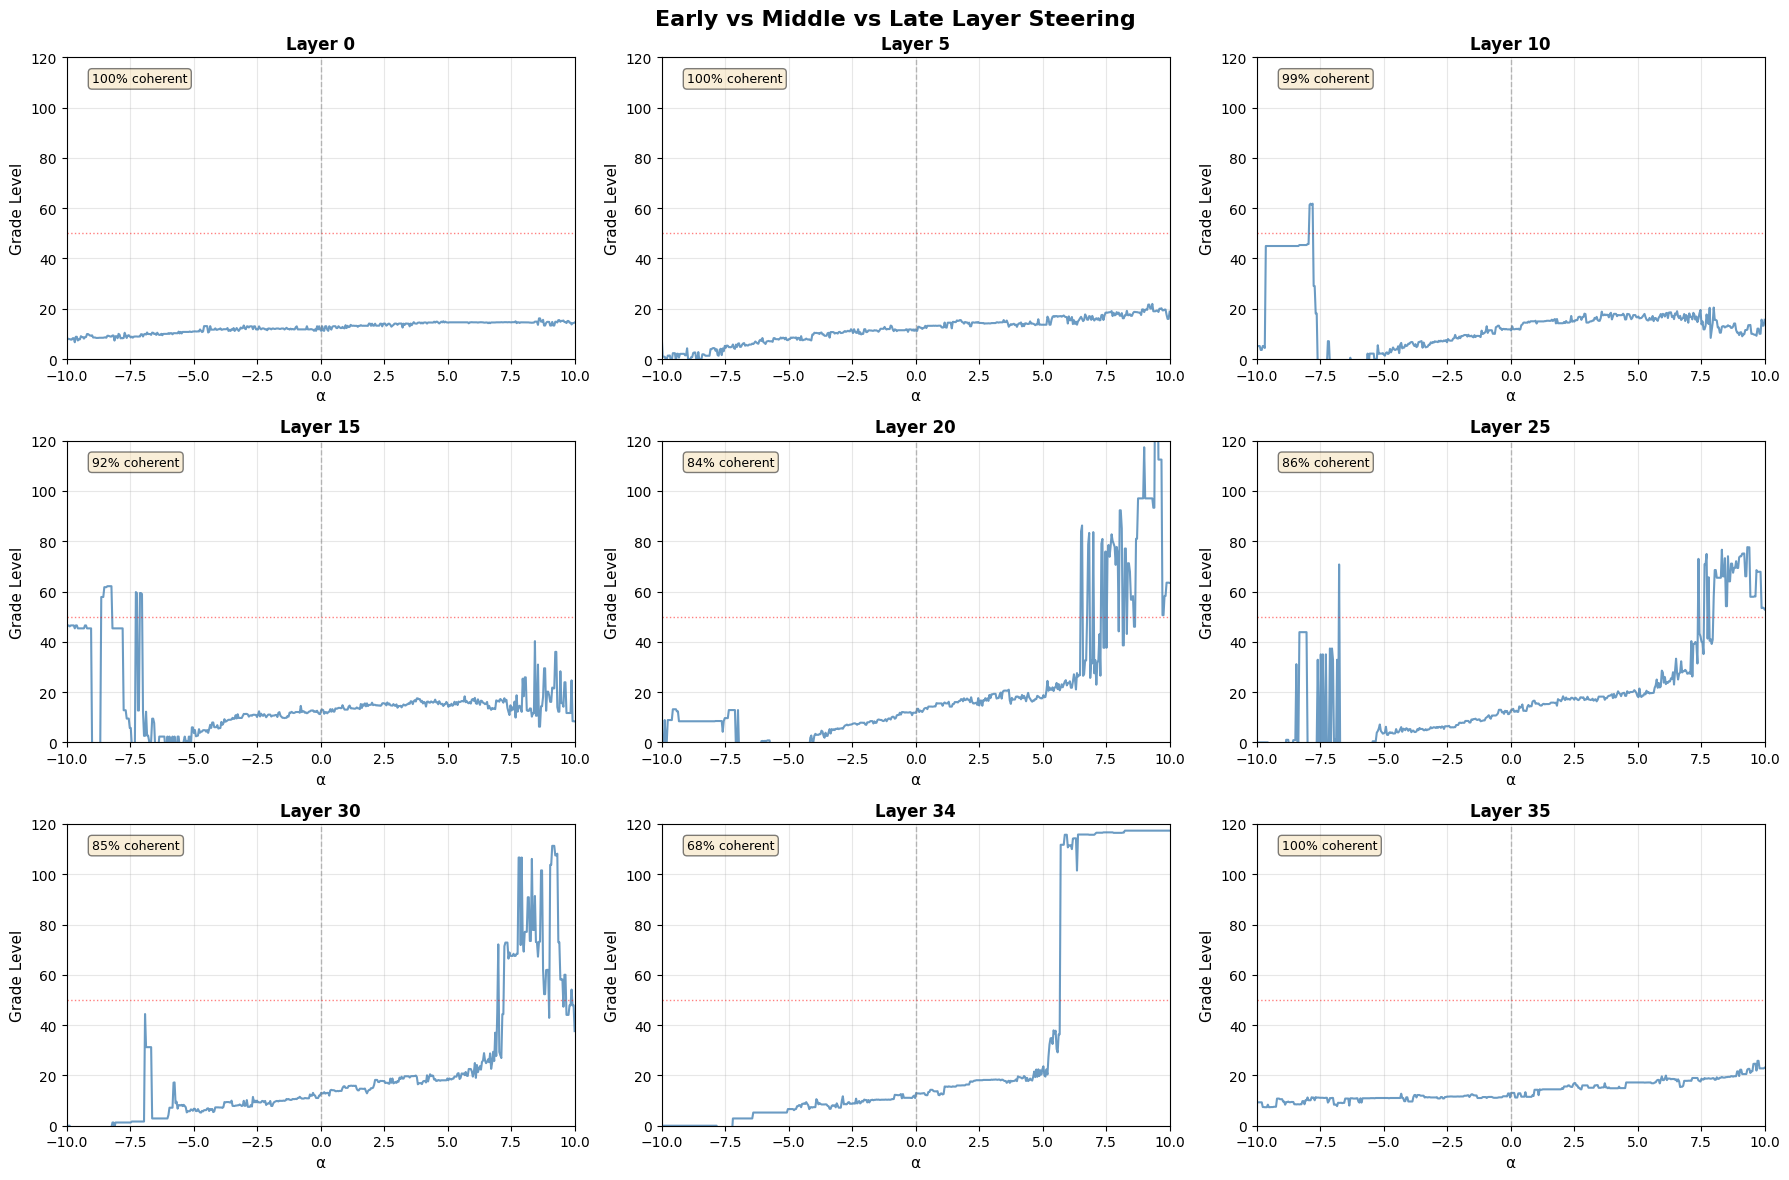

In [14]:
# Compare representative layers from each section
early_layers = [0, 5, 10]
middle_layers = [15, 20, 25]
late_layers = [30, 34, 35]

fig, axes = plt.subplots(3, 3, figsize=(18, 12))

for i, layers in enumerate([early_layers, middle_layers, late_layers]):
    section_name = ['Early (0-10)', 'Middle (15-25)', 'Late (30-35)'][i]
    for j, layer in enumerate(layers):
        ax = axes[i, j]
        layer_df = df[df['layer'] == layer]
        
        ax.plot(layer_df['alpha'], layer_df['grade_level'], linewidth=1.5, color='steelblue', alpha=0.8)
        ax.axvline(0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
        ax.axhline(50, color='red', linestyle=':', alpha=0.5, linewidth=1)
        
        ax.set_xlabel('α', fontsize=11)
        ax.set_ylabel('Grade Level', fontsize=11)
        ax.set_title(f'Layer {layer}', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 120)
        ax.set_xlim(-10, 10)
        
        # Add coherent fraction as text
        coh_frac = layer_stats_df[layer_stats_df['layer'] == layer]['coherent_fraction'].values[0]
        ax.text(0.05, 0.95, f'{coh_frac*100:.0f}% coherent', 
                transform=ax.transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

fig.suptitle('Early vs Middle vs Late Layer Steering', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Deep Dive: Layer 34 vs Layer 35

Compare the "best extraction layer" (34) with the "perfectly coherent final layer" (35).

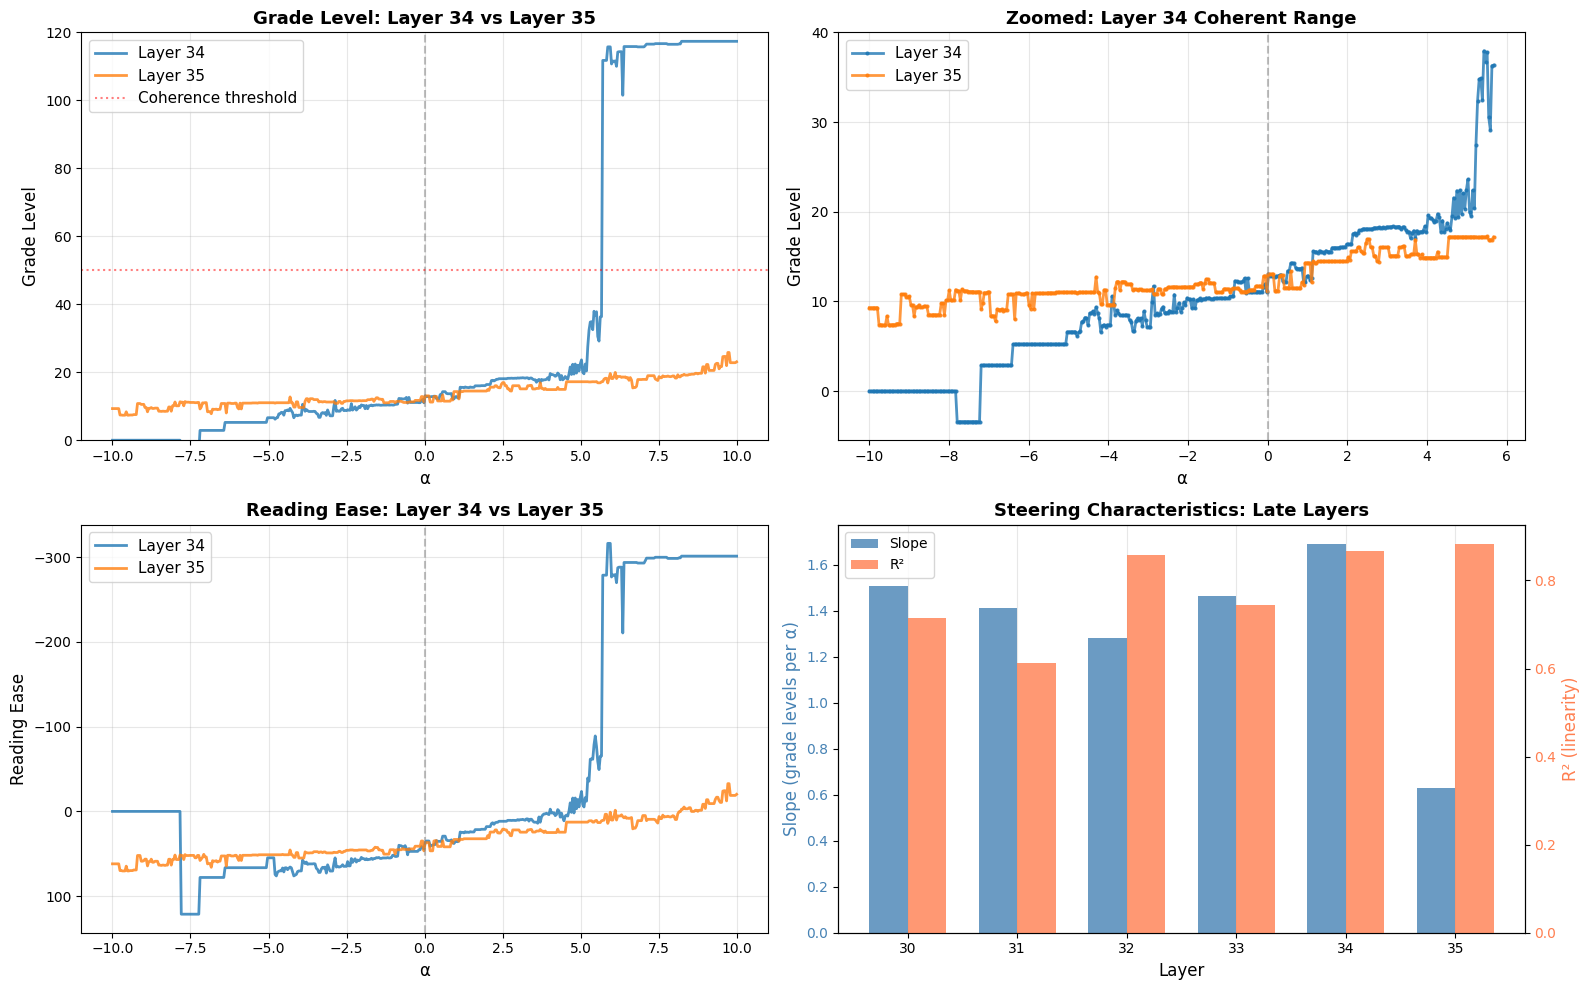

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Grade level comparison
ax = axes[0, 0]
layer_34_df = df[df['layer'] == 34]
layer_35_df = df[df['layer'] == 35]

ax.plot(layer_34_df['alpha'], layer_34_df['grade_level'], linewidth=2, label='Layer 34', alpha=0.8)
ax.plot(layer_35_df['alpha'], layer_35_df['grade_level'], linewidth=2, label='Layer 35', alpha=0.8)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax.axhline(50, color='red', linestyle=':', alpha=0.5, label='Coherence threshold')
ax.set_xlabel('α', fontsize=12)
ax.set_ylabel('Grade Level', fontsize=12)
ax.set_title('Grade Level: Layer 34 vs Layer 35', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 120)

# Plot 2: Zoomed coherent region
ax = axes[0, 1]
# Focus on coherent region for layer 34
layer_34_coherent = layer_34_df[layer_34_df['grade_level'] < 50]
alpha_min_34 = layer_34_coherent['alpha'].min()
alpha_max_34 = layer_34_coherent['alpha'].max()

zoom_df_34 = layer_34_df[(layer_34_df['alpha'] >= alpha_min_34) & (layer_34_df['alpha'] <= alpha_max_34)]
zoom_df_35 = layer_35_df[(layer_35_df['alpha'] >= alpha_min_34) & (layer_35_df['alpha'] <= alpha_max_34)]

ax.plot(zoom_df_34['alpha'], zoom_df_34['grade_level'], 'o-', linewidth=2, markersize=2, label='Layer 34', alpha=0.8)
ax.plot(zoom_df_35['alpha'], zoom_df_35['grade_level'], 'o-', linewidth=2, markersize=2, label='Layer 35', alpha=0.8)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('α', fontsize=12)
ax.set_ylabel('Grade Level', fontsize=12)
ax.set_title(f'Zoomed: Layer 34 Coherent Range', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Plot 3: Reading ease comparison
ax = axes[1, 0]
ax.plot(layer_34_df['alpha'], layer_34_df['reading_ease'], linewidth=2, label='Layer 34', alpha=0.8)
ax.plot(layer_35_df['alpha'], layer_35_df['reading_ease'], linewidth=2, label='Layer 35', alpha=0.8)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('α', fontsize=12)
ax.set_ylabel('Reading Ease', fontsize=12)
ax.set_title('Reading Ease: Layer 34 vs Layer 35', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.invert_yaxis()

# Plot 4: Slope comparison (in coherent regions)
ax = axes[1, 1]
slopes = []
r_squareds = []
layers_to_compare = [30, 31, 32, 33, 34, 35]

for layer in layers_to_compare:
    stats = layer_stats_df[layer_stats_df['layer'] == layer].iloc[0]
    slopes.append(stats['slope'])
    r_squareds.append(stats['r_squared'])

x = np.arange(len(layers_to_compare))
width = 0.35

ax2 = ax.twinx()
bars1 = ax.bar(x - width/2, slopes, width, label='Slope', alpha=0.8, color='steelblue')
bars2 = ax2.bar(x + width/2, r_squareds, width, label='R²', alpha=0.8, color='coral')

ax.set_xlabel('Layer', fontsize=12)
ax.set_ylabel('Slope (grade levels per α)', fontsize=12, color='steelblue')
ax2.set_ylabel('R² (linearity)', fontsize=12, color='coral')
ax.set_title('Steering Characteristics: Late Layers', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(layers_to_compare)
ax.tick_params(axis='y', labelcolor='steelblue')
ax2.tick_params(axis='y', labelcolor='coral')
ax.grid(True, alpha=0.3, axis='x')

# Add legends
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

## Text Analysis: Layer 34 vs 35 at Extreme α

Compare actual outputs at α=±10 to see semantic differences.

In [16]:
# Sample outputs at extreme α values
test_alphas = [-10, 0, 5, 10]
test_layers = [34, 35]

for alpha in test_alphas:
    print(f"\n{'='*100}")
    print(f"α = {alpha}")
    print(f"{'='*100}")
    
    for layer in test_layers:
        layer_df = df[df['layer'] == layer]
        # Find closest α
        idx = (layer_df['alpha'] - alpha).abs().idxmin()
        row = layer_df.loc[idx]
        
        print(f"\n--- Layer {layer} ---")
        print(f"Grade Level: {row['grade_level']:.1f} | Reading Ease: {row['reading_ease']:.1f}")
        print(f"Words: {row['n_words']} | Coherent: {row['coherent']}")
        print(f"\nText (first 300 chars):")
        print(row['completion'][:300])
        if len(row['completion']) > 300:
            print("...")


α = -10

--- Layer 34 ---
Grade Level: 0.0 | Reading Ease: 0.0
Words: 125 | Coherent: True

Text (first 300 chars):
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  

...

--- Layer 35 ---
Grade Level: 9.3 | Reading Ease: 61.9
Words: 207 | Coherent: True

Text (first 300 chars):
Quantum mechanics is a branch of physics that describes the behavior of matter and energy at the smallest scales, like atoms and subatomic particles. Unlike everyday experiences where things have definite positions and speeds, in the quantum world, particles can exist in a kind of "blur" of possibil
...

α = 0

--- Layer 34 ---
Grade Level: 11.0 | Reading Ease: 44.1
Words: 204 | Coherent: True

Text (first 300 chars):
Quantum mechanics is a fundamental theory in ph

## Hypothesis Testing

### Hypothesis 1: Layer 35 is a "post-processing" layer

**Evidence:**
- 100% coherent across entire α ∈ [-10, 10] range
- Linear response (high R²)
- Smaller Euclidean norm (24.37 vs 62.44 for layer 34)
- Final layer before unembedding

**Interpretation:** Layer 35 may be performing final adjustments to representations that are already "almost tokens". Steering here might be more like adjusting a dimmer switch rather than changing which room you're in.

### Hypothesis 2: Layers 32-34 are the "semantic battleground"

**Evidence:**
- Dramatic drop in coherent fraction (74%, 63%, 68%)
- Narrow α boundaries (~7-8 range width)
- Highest steering vector norms

**Interpretation:** These layers are where semantic content is being finalized. Steering here has powerful effects but tight boundaries - this is where the model is making critical decisions about meaning.

### Hypothesis 3: Early layers are "semantically inert" for this task

**Evidence:**
- Layers 0-5: 100% or near-100% coherent
- Very low steering vector norms (0.42 - 11.47)
- Minimal grade level variation

**Interpretation:** Early layers haven't yet formed the semantic representations that our complexity vectors target. Steering them is like trying to steer a car that hasn't started yet - nothing bad happens, but nothing much happens at all.

## Summary Statistics Table

In [17]:
# Create a summary table
summary = layer_stats_df[[
    'layer', 'coherent_fraction', 'mean_grade_level', 'grade_range', 'slope', 'r_squared'
]].copy()

# Add layer grouping
def categorize_layer(layer):
    if layer < 12:
        return 'Early'
    elif layer < 24:
        return 'Middle'
    else:
        return 'Late'

summary['group'] = summary['layer'].apply(categorize_layer)

# Group statistics
print("\n=== Summary by Layer Group ===")
print(summary.groupby('group')[['coherent_fraction', 'mean_grade_level', 'slope']].agg(['mean', 'std']))

# Highlight interesting layers
print("\n=== Interesting Layers ===")
print("\nMost coherent:")
print(summary.nlargest(5, 'coherent_fraction')[['layer', 'coherent_fraction', 'slope', 'r_squared']])

print("\nLeast coherent:")
print(summary.nsmallest(5, 'coherent_fraction')[['layer', 'coherent_fraction', 'slope', 'r_squared']])

print("\nSteepest slope (strongest effect):")
print(summary.nlargest(5, 'slope')[['layer', 'slope', 'coherent_fraction', 'r_squared']])

print("\nMost linear (highest R²):")
print(summary.nlargest(5, 'r_squared')[['layer', 'r_squared', 'slope', 'coherent_fraction']])


=== Summary by Layer Group ===
       coherent_fraction           mean_grade_level               slope  \
                    mean       std             mean       std      mean   
group                                                                     
Early           0.974500  0.034113        12.103468  0.983776  0.499311   
Late            0.815833  0.098776        12.832851  1.048591  1.381700   
Middle          0.910333  0.049144        13.866264  2.267000  0.611987   

                  
             std  
group             
Early   0.411619  
Late    0.379511  
Middle  0.725218  

=== Interesting Layers ===

Most coherent:
   layer  coherent_fraction     slope  r_squared
0      0                1.0  0.342354   0.879111
2      2                1.0  0.584710   0.781901
3      3                1.0  0.748921   0.869942
4      4                1.0  0.780732   0.906770
5      5                1.0  0.858242   0.914457

Least coherent:
    layer  coherent_fraction     slope  r_square

## Conclusions

**Key findings:**

1. **Layer architecture matters**: The model shows three distinct steering regimes:
   - Early (0-11): High coherence, weak effects, low norms
   - Middle (12-23): Moderate coherence, increasing effects
   - Late (24-35): Variable behavior, strongest effects, tight boundaries

2. **The Layer 34 vs 35 paradox**: 
   - Layer 34: Strong effects, narrow safe zone, "true semantic steering"
   - Layer 35: Gentle effects, infinite safe zone, "post-processing adjustment"
   - This suggests the final layer operates in a fundamentally different regime

3. **The death zone (32-34)**: These layers show the most dramatic steering effects but also the narrowest boundaries. This is where semantic decisions are being finalized.

4. **Linear representation hypothesis validation**: The high R² values in many layers support the idea that concepts are represented as directions. Layer 35 in particular shows near-perfect linearity (R² ≈ 1.0).

**Implications for steering applications:**
- Use layer 35 for "safe" steering with predictable effects
- Use layers 32-34 for powerful semantic shifts (but stay within boundaries)
- Early layers are probably not worth steering for this type of semantic manipulation

**Next steps:**
- Add perplexity measurements to detect off-manifold excursions
- Test whether layer 35's behavior generalizes to other prompts
- Investigate whether combining multi-layer steering can expand usable boundaries

## Signal Processing Analysis: Extracting the Common Signal

All 36 layers show a "bottom-left to top-right" trend, suggesting a common underlying steering signal. Let's extract this consensus signal and measure each layer's SNR.

In [18]:
# Create pivot table: rows = layers, columns = α values
pivot = df.pivot_table(index='layer', columns='alpha', values='grade_level', aggfunc='mean')

print(f"Response matrix shape: {pivot.shape}")
print(f"  Layers: {pivot.shape[0]}")
print(f"  α values: {pivot.shape[1]}")

Response matrix shape: (36, 500)
  Layers: 36
  α values: 500


### Extract Consensus Signal

Two approaches:
1. **Mean response** across all layers (simple average)
2. **Median response** across all layers (robust to outliers)

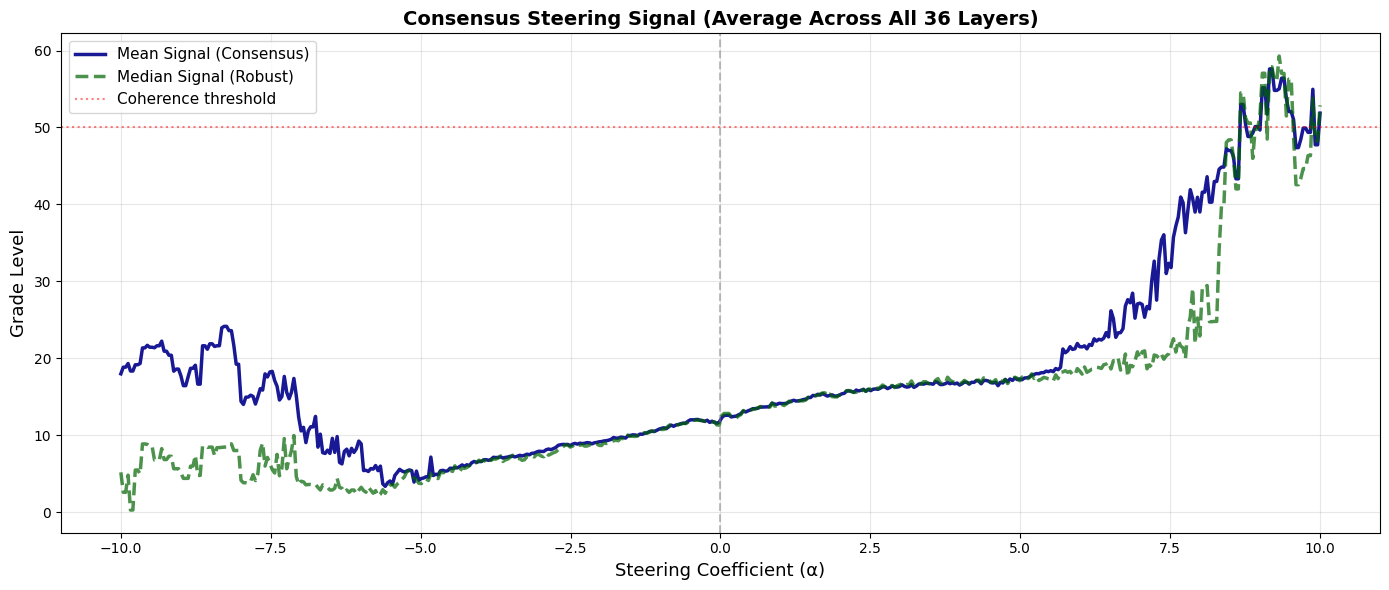


Consensus signal statistics:
  Mean signal: 18.36 ± 12.51
  Median signal: 14.86 ± 12.28


In [19]:
# Compute consensus signals
mean_signal = pivot.mean(axis=0)  # Mean across layers for each α
median_signal = pivot.median(axis=0)  # Median across layers for each α

# Plot both
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(mean_signal.index, mean_signal.values, linewidth=2.5, label='Mean Signal (Consensus)', color='darkblue', alpha=0.9)
ax.plot(median_signal.index, median_signal.values, linewidth=2.5, label='Median Signal (Robust)', color='darkgreen', alpha=0.7, linestyle='--')
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax.axhline(50, color='red', linestyle=':', alpha=0.5, label='Coherence threshold')

ax.set_xlabel('Steering Coefficient (α)', fontsize=13)
ax.set_ylabel('Grade Level', fontsize=13)
ax.set_title('Consensus Steering Signal (Average Across All 36 Layers)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nConsensus signal statistics:")
print(f"  Mean signal: {mean_signal.mean():.2f} ± {mean_signal.std():.2f}")
print(f"  Median signal: {median_signal.mean():.2f} ± {median_signal.std():.2f}")

### Compute Signal-to-Noise Ratio (SNR) by Layer

For each layer, we compute:
- **Signal power**: Variance of the mean signal
- **Noise power**: Variance of residuals (layer response - mean signal)
- **SNR (dB)**: $10 \log_{10}(\frac{\text{signal power}}{\text{noise power}})$

In [20]:
# Compute SNR for each layer
signal_power = np.var(mean_signal)  # Power of consensus signal

snr_results = []
for layer in range(36):
    layer_response = pivot.loc[layer]
    residuals = layer_response - mean_signal  # Deviation from consensus
    noise_power = np.var(residuals)
    
    # SNR in dB
    if noise_power > 0:
        snr_db = 10 * np.log10(signal_power / noise_power)
    else:
        snr_db = np.inf
    
    # Correlation with consensus signal
    correlation = np.corrcoef(layer_response, mean_signal)[0, 1]
    
    # RMS error from consensus
    rmse = np.sqrt(np.mean(residuals**2))
    
    snr_results.append({
        'layer': layer,
        'snr_db': snr_db,
        'correlation': correlation,
        'rmse': rmse,
        'noise_power': noise_power,
    })

snr_df = pd.DataFrame(snr_results)

print("\nSNR by layer:")
print(snr_df.to_string(index=False))


SNR by layer:
 layer    snr_db  correlation      rmse  noise_power
     0  0.574361     0.450900 13.135922   136.767497
     1  1.214139     0.523799 12.083744   118.033454
     2  0.567285     0.353057 13.705231   136.990502
     3  0.922859     0.443349 13.378275   126.221423
     4  1.135808     0.492911 12.957561   120.181644
     5  1.389849     0.537300 12.680793   113.353281
     6 -0.840677     0.728278 13.832308   189.446527
     7 -0.730063     0.482048 14.553065   184.682322
     8 -2.524820     0.223933 17.164620   279.190754
     9 -1.109542     0.369157 14.970136   201.545541
    10 -1.853720     0.217563 16.077358   239.216439
    11 -0.703594     0.803977 13.635201   183.560127
    12 -0.635590     0.642608 13.457254   180.708253
    13  1.121102     0.723918 11.138745   120.589315
    14 -1.816319     0.280375 15.533558   237.165172
    15 -1.963217     0.268409 15.896891   245.324350
    16  2.314227     0.659166 10.016512    91.621260
    17 -0.632279     0.623581 1

### Visualization: SNR and Correlation by Layer

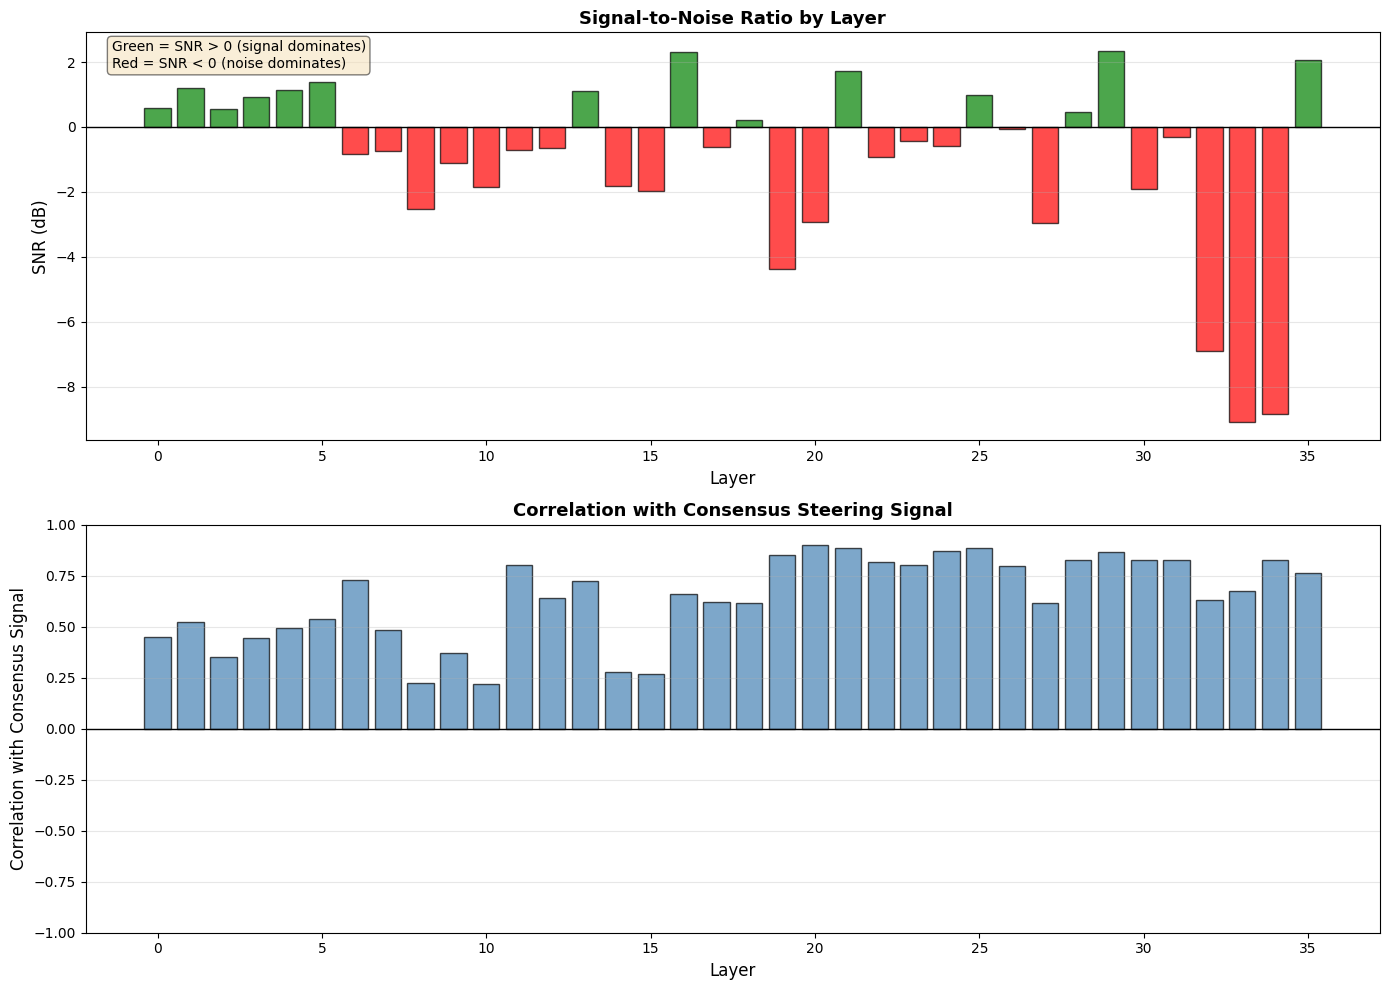

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: SNR by layer
ax = axes[0]
colors = ['green' if snr > 0 else 'red' for snr in snr_df['snr_db']]
ax.bar(snr_df['layer'], snr_df['snr_db'], color=colors, alpha=0.7, edgecolor='black')
ax.axhline(0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Layer', fontsize=12)
ax.set_ylabel('SNR (dB)', fontsize=12)
ax.set_title('Signal-to-Noise Ratio by Layer', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticks(range(0, 36, 5))

# Add text annotation
ax.text(0.02, 0.98, 'Green = SNR > 0 (signal dominates)\nRed = SNR < 0 (noise dominates)', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Correlation with consensus
ax = axes[1]
ax.bar(snr_df['layer'], snr_df['correlation'], color='steelblue', alpha=0.7, edgecolor='black')
ax.axhline(0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Layer', fontsize=12)
ax.set_ylabel('Correlation with Consensus Signal', fontsize=12)
ax.set_title('Correlation with Consensus Steering Signal', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticks(range(0, 36, 5))
ax.set_ylim(-1, 1)

plt.tight_layout()
plt.show()

### Identify High-SNR and Low-SNR Layers

In [22]:
print("\n=== Highest SNR Layers (Cleanest Signal) ===")
print(snr_df.nlargest(10, 'snr_db')[['layer', 'snr_db', 'correlation', 'rmse']])

print("\n=== Lowest SNR Layers (Noisiest) ===")
print(snr_df.nsmallest(10, 'snr_db')[['layer', 'snr_db', 'correlation', 'rmse']])

print("\n=== Highest Correlation with Consensus ===")
print(snr_df.nlargest(10, 'correlation')[['layer', 'correlation', 'snr_db', 'rmse']])


=== Highest SNR Layers (Cleanest Signal) ===
    layer    snr_db  correlation       rmse
29     29  2.343056     0.868639   9.551010
16     16  2.314227     0.659166  10.016512
35     35  2.051165     0.761847  10.876152
21     21  1.724181     0.884173  10.254591
5       5  1.389849     0.537300  12.680793
1       1  1.214139     0.523799  12.083744
4       4  1.135808     0.492911  12.957561
13     13  1.121102     0.723918  11.138745
25     25  0.974873     0.884451  11.169500
3       3  0.922859     0.443349  13.378275

=== Lowest SNR Layers (Noisiest) ===
    layer    snr_db  correlation       rmse
33     33 -9.082912     0.675914  45.050917
34     34 -8.840252     0.826611  37.547948
32     32 -6.894676     0.629947  31.169502
19     19 -4.369952     0.850347  20.718782
27     27 -2.967629     0.615106  18.096274
20     20 -2.935109     0.900638  17.739881
8       8 -2.524820     0.223933  17.164620
15     15 -1.963217     0.268409  15.896891
30     30 -1.926415     0.829316  15

### Visualization: Signal + Noise Decomposition (Selected Layers)

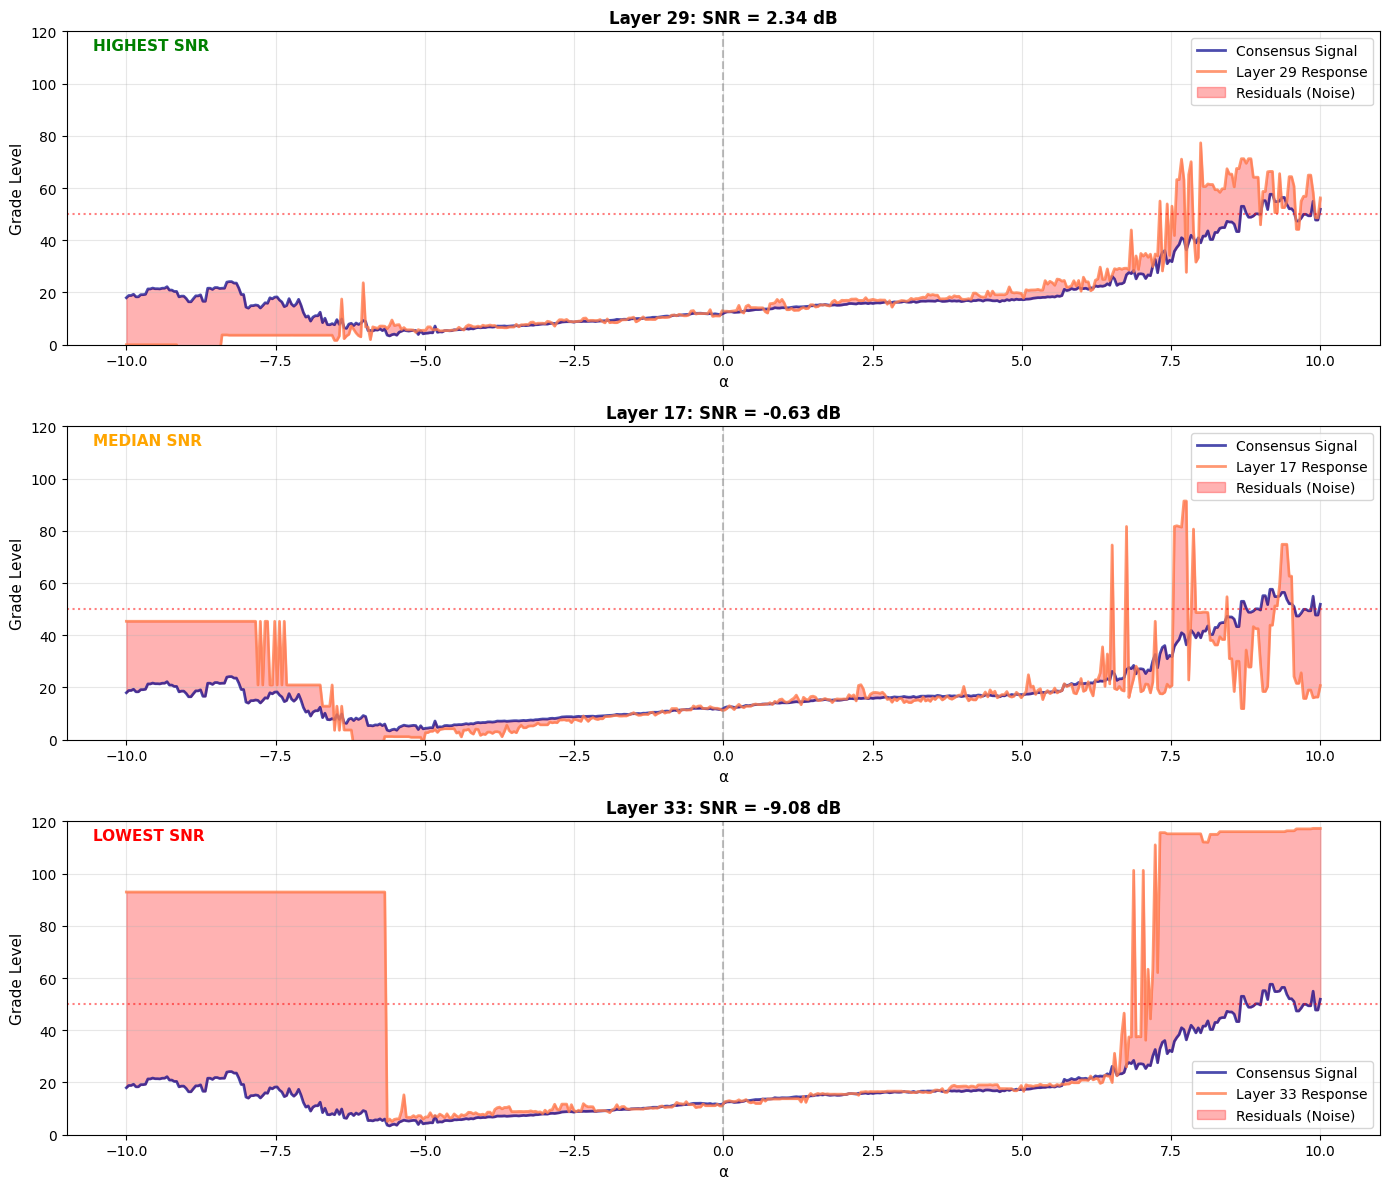

In [23]:
# Show signal + noise decomposition for high/medium/low SNR layers
high_snr_layer = snr_df.nlargest(1, 'snr_db')['layer'].values[0]
mid_snr_layer = snr_df.nsmallest(18, 'snr_db').nlargest(1, 'snr_db')['layer'].values[0]  # Median SNR
low_snr_layer = snr_df.nsmallest(1, 'snr_db')['layer'].values[0]

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

for idx, (layer, ax) in enumerate(zip([high_snr_layer, mid_snr_layer, low_snr_layer], axes)):
    layer_response = pivot.loc[layer]
    residuals = layer_response - mean_signal
    snr = snr_df[snr_df['layer'] == layer]['snr_db'].values[0]
    
    ax.plot(mean_signal.index, mean_signal.values, linewidth=2, label='Consensus Signal', color='darkblue', alpha=0.7)
    ax.plot(layer_response.index, layer_response.values, linewidth=2, label=f'Layer {layer} Response', color='coral', alpha=0.8)
    ax.fill_between(layer_response.index, mean_signal.values, layer_response.values, 
                     alpha=0.3, color='red', label='Residuals (Noise)')
    ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
    ax.axhline(50, color='red', linestyle=':', alpha=0.5)
    
    ax.set_xlabel('α', fontsize=11)
    ax.set_ylabel('Grade Level', fontsize=11)
    ax.set_title(f'Layer {layer}: SNR = {snr:.2f} dB', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 120)

axes[0].text(0.02, 0.98, 'HIGHEST SNR', transform=axes[0].transAxes, fontsize=11, 
             fontweight='bold', verticalalignment='top', color='green')
axes[1].text(0.02, 0.98, 'MEDIAN SNR', transform=axes[1].transAxes, fontsize=11, 
             fontweight='bold', verticalalignment='top', color='orange')
axes[2].text(0.02, 0.98, 'LOWEST SNR', transform=axes[2].transAxes, fontsize=11, 
             fontweight='bold', verticalalignment='top', color='red')

plt.tight_layout()
plt.show()